In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import itertools

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

import importlib

import analysis_functions

In [2]:
##### read in datafile after removing false transition and checking convergence  ######
dataDir='.'
simDataDir='/'.join([dataDir,''])
simDataFilename='script_data/Simulation_Milestone_Coordinate_Data.cAMP_newTransit.csv'
#index22DataFilename='script_data/Simulation_Milestone_Coordinate_Data.cAMP_newTransit.09.28.csv'
#oldDataFilename='Simulation_Milestone_Coordinate_Data.cAMP_newTransit_08.31.csv'
#simDataFilePath='/'.join([simDataDir,simDataFilename])
simData=pd.read_csv(simDataFilename)
#oldData=pd.read_csv(oldDataFilename)
#index22Data=pd.read_csv(index22DataFilename)
simData.tail()
#oldData.tail()

,Window,Rep,Time,Rst06_X,Rst06_Y,Rst07_Z,Rst08_Z,X_Index,R
14549179,52,5,2285000.0,0.128,29.656,4.467,113.971,52,29.656276
14549180,52,5,2285500.0,0.345,29.897,4.282,114.130,52,29.898991
14549181,52,5,2286000.0,0.698,29.651,5.180,113.227,52,29.659215
14549182,52,5,2286500.0,0.448,29.854,4.704,113.713,52,29.857361
14549183,52,5,2288000.0,0.011,29.984,5.253,113.175,52,29.984002


In [3]:
##### reverse Window and X_Index for backward MFPT ########
revData=pd.read_csv(simDataFilename)
revData.Window=52-revData.Window
revData.X_Index=52-revData.X_Index
revData.head()

,Window,Rep,Time,Rst06_X,Rst06_Y,Rst07_Z,Rst08_Z,X_Index,R
0,52,1,0.0,4.291,17.350,107.903,10.456,52,17.872750
1,52,1,500.0,4.117,17.984,108.105,10.275,52,18.449226
2,52,1,1000.0,4.162,17.821,108.509,9.857,52,18.300554
3,52,1,1500.0,4.621,17.773,107.792,10.539,52,18.363909
4,52,1,2000.0,4.761,17.909,108.495,9.874,52,18.531039


# **Milestoning equations**

Given milstone state $S_{ij}$ is the boundary between two adjacent Voronoi cells $B_i$ and $B_j$, and milestone state $S_{ik}$ are the boundary between two adjacent Voronoi cells $B_i$ and $B_k$. 

$k_{i→j}$ is the rate of attempted escape from cells $B_i$ to $B_j$.
At statistical equilibrium, the total flux in and out of each cell is zero, thus the equilibrium probability $\pi_i$ for the system to locate in cell $B_i$ satisfies a balance equation: 
$$\sum_{j=1,j\neq i} \pi_{j}k_{j→i}=\sum_{j=1, j\neq i} \pi_{i}k_{i→j} , \space \sum_{i=1} \pi_i =1 $$

The solution gives the equilibrium probability $\pi_i$ and consequently the free energy $-k_B Tln(\pi_i)$.

For each individual cell, 
let $q_{ij,ik}$ be the rate of moving from milestone state $S_{ij}$ to $S_{ik}$;

$n_{ij,ik}^i$ is the number of attemped transitions from $S_{ij}$ to $S_{ik}$, normalized by the time spend in cell $B_i$;

$r_{ij}^i$ is the time after having hit $S_{ij}$ before hitting any other milestone state, normalized by the total time spend in cell $B_i$: 

$$q_{ij,ik}= \frac{\pi_i n_{ij,ik}^i}{\pi_i r_{ij}^i +\pi_j r_{ij}^i }$$

The MFPT between milestone state $S_{ij}$ to $S_{ik}$ can be calculated from $q_{ij,ik}$.


In [4]:
########## use analysis_function.py to calculate Escape_vector and Reentry_vector #########
### for example, for window==50, Escape_Vector.unique() is [50 49 -1 51], Reentry_Vector.unique() is [-1 49 51]

simData['Frame']=simData['Time']
analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
    simData,
    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
analysisFrame.tail()

#### for old data ####

#oldData['Frame']=oldData['Time']
#old_analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
#    oldData,
#    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
#    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
#old_analysisFrame.tail()


#### for index22 data ####

#index22Data['Frame']=index22Data['Time']
#index22_analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
#    index22Data,
#    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
#    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
#index22_analysisFrame.tail()

analysis_functions.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  simData[groupingCol]=0
analysis_functions.py:434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  simData[repCol]=milestoneData[repCol]
analysis_functions.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  simData[frameCol]=milestoneData[frameCo

--- --- --- Grouping Name: 0 --- --- ---
	binSet: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] ; deltaVal: 1
	--- --- Window Name: 0 --- ---
		--- Replica Name: 1 

analysis_functions.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  repData['Escape_Vector']=binVec-deltaVal
analysis_functions.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  repData['Reentry_Vector']=reentryVec-deltaVal


2 3 4 5 6 ---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 1 2 3 4 5 6 7 8 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 1 3 4 5 6 7 8 9 10 11 12 13 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 1 2 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 2 4 5 6 7 8 9 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 1 3 4 5 6 7 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 1 3 4 5 6 7 8 9 10 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 2 4 5 6 7 8 9 10 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 1 3 4 5 6 7 8 9 10 11 ---
	--- --- ------ --- ---
	--- --- Window Name: 9 --- ---
		--- Replica Name: 6 7 8 9 10 11 12 13 ---
	--- --- ------ --- ---
	--- --- Window Name: 10 --- ---
		--- Replica Name: 1 2 3 4 5 6 7 8 9 10 11 ---
	--

,Window,X_Index,Group,Rep,Frame,Escape_Vector,Reentry_Vector
14549179,52,52,0,5,2285000.0,52,51
14549180,52,52,0,5,2285500.0,52,51
14549181,52,52,0,5,2286000.0,52,51
14549182,52,52,0,5,2286500.0,52,51
14549183,52,52,0,5,2288000.0,52,51


In [5]:
###### calucalate Escape_vector and Reentry_vector for backward transition #########
revData['Frame']=revData['Time']
rev_analysisFrame=analysis_functions.add_indexed_milestoning_analysis_columns(
    revData,
    windowColumn='Window',xIndexColumn='X_Index',frameCol='Frame',
    repColumn='Rep',groupingColumn=None,verbose=True,verboseLevel=1)
rev_analysisFrame.tail()

--- --- --- Grouping Name: 0 --- --- ---
	binSet: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52] ; deltaVal: 1
	--- --- Window Name: 0 --- ---
		--- Replica Name: 1 2 3 4 5 ---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 1 2 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 1 3 4 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 1 2 3 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 1 2 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 1 2 3 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 1 2 3 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 1 2 3 4 5 6 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 1 2 3 4 5 6 ---
	--- --- --

,Window,X_Index,Group,Rep,Frame,Escape_Vector,Reentry_Vector
115968,52,52,0,6,4997500.0,52,51
115969,52,52,0,6,4998000.0,52,51
115970,52,52,0,6,4998500.0,52,51
115971,52,52,0,6,4999000.0,52,51
115972,52,52,0,6,4999500.0,52,51


('binSet', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52], dtype=int64))


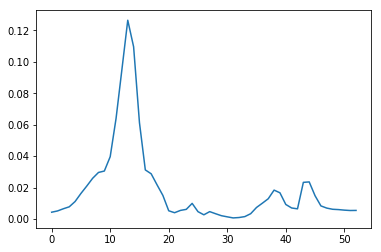

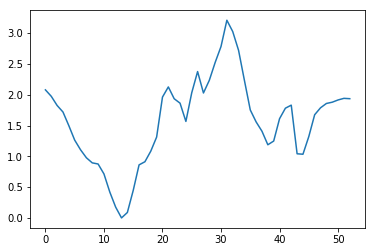

In [6]:
#################### pi_vector and PMF ################

kb=0.001985875 #kcal/mol
simTemp=310.15
kbT=kb*simTemp

binSet=np.sort(np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Index'].unique()
])))
print("binSet",binSet)

testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)
#print('testEscapeData:',testEscapeData)

## for old data pi_vector and PMF ##
#old_EscapeData=analysis_functions.compute_analysis_group_pi_vector(
#    groupDataFrame=old_analysisFrame,windowColumn='Window',binSet=binSet,
#    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
#    giveCountsMat=True)

## for index22 data pi_vector and PMF ##
#index22_EscapeData=analysis_functions.compute_analysis_group_pi_vector(
#    groupDataFrame=index22_analysisFrame,windowColumn='Window',binSet=binSet,
#    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
#    giveCountsMat=True)

rev_testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=rev_analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)

# piVec is the eigenvec of escapMat, whose eigenval is 1. Sum of piVec is 1
# i.e. escapeEig=np.linalg.eig(escapeMat.todense().T), piVec=np.array(escapeEig[1])
plt.plot(testEscapeData['piVec'])
plt.show()
tempVec=-kbT*np.log(testEscapeData['piVec']) #-log(piVec) is PMF in kT
tempVec=tempVec-np.min(tempVec)
plt.plot(tempVec)
#plt.yticks(np.arange(0,5,0.5))
#plt.grid( linestyle='-', linewidth=1)
plt.show()




In [7]:
############### Compute transition rate matrix ##################
#importlib.reload(analysis_functions)
QdataDict=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
                                     giveBins=False,giveBinMap=False,
                                     giveEscapeMat=True,giveCounts=False,
                                     giveCountsMat=False,givePiVec=True)
for entryKey in QdataDict:
    print(entryKey,':',QdataDict[entryKey])

### for old data computing transition rate matrix ###
#old_QdataDict=analysis_functions.compute_analysis_group_Qdata(
#    groupDataFrame=old_analysisFrame,windowColumn='Window',binSet=binSet,
                                    # giveBins=False,giveBinMap=False,
                                    # giveEscapeMat=True,giveCounts=False,
                                    # giveCountsMat=False,givePiVec=True)
#for entryKey in old_QdataDict:
#    print(entryKey,':',old_QdataDict[entryKey])

    
### for index22 data computing transition rate matrix ###
#index22_QdataDict=analysis_functions.compute_analysis_group_Qdata(
#    groupDataFrame=index22_analysisFrame,windowColumn='Window',binSet=binSet,
#                                     giveBins=False,giveBinMap=False,
#                                     giveEscapeMat=True,giveCounts=False,
#                                     giveCountsMat=False,givePiVec=True)
#for entryKey in index22_QdataDict:
#    print(entryKey,':',index22_QdataDict[entryKey])

Computing R and N: ( 0 : 1 2 3 4 5 6 ) ( 1 : 1 2 3 4 5 6 7 8 ) ( 2 : 1 3 4 5 6 7 8 9 10 11 12 13 ) ( 3 : 1 2 3 4 5 ) ( 4 : 2 4 5 6 7 8 9 ) ( 5 : 1 3 4 5 6 7 ) ( 6 : 1 3 4 5 6 7 8 9 10 ) ( 7 : 2 4 5 6 7 8 9 10 ) ( 8 : 1 3 4 5 6 7 8 9 10 11 ) ( 9 : 6 7 8 9 10 11 12 13 ) ( 10 : 1 2 3 4 5 6 7 8 9 10 11 ) ( 11 : 1 2 3 4 5 6 7 ) ( 12 : 1 2 3 4 5 6 ) ( 13 : 1 3 4 5 ) ( 14 : 1 2 3 4 5 6 ) ( 15 : 1 2 3 ) ( 16 : 1 2 3 4 ) ( 17 : 1 2 3 4 ) ( 18 : 1 2 3 4 ) ( 19 : 1 2 3 4 5 ) ( 20 : 1 ) ( 21 : 1 2 ) ( 22 : 3 ) ( 23 : 1 ) ( 24 : 3 ) ( 25 : 1 ) ( 26 : 1 ) ( 27 : 1 2 ) ( 28 : 1 ) ( 29 : 3 ) ( 30 : 1 ) ( 31 : 1 ) ( 32 : 1 ) ( 33 : 1 ) ( 34 : 1 ) ( 35 : 4 5 ) ( 36 : 1 ) ( 37 : 1 2 3 4 ) ( 38 : 1 ) ( 39 : 1 ) ( 40 : 1 ) ( 41 : 1 ) ( 42 : 1 ) ( 43 : 1 3 4 5 6 7 ) ( 44 : 1 2 3 4 5 6 ) ( 45 : 1 2 3 4 5 6 ) ( 46 : 1 2 3 ) ( 47 : 1 2 3 ) ( 48 : 1 2 ) ( 49 : 1 2 3 ) ( 50 : 1 3 4 ) ( 51 : 1 2 ) ( 52 : 1 2 3 4 5 ) 
('Rmat', ':', <53x53 sparse matrix of type '<type 'numpy.float64'>'
	with 104 stored elements in 

In [8]:
################ Compute transition rate matrix for backward transition ############
rev_QdataDict=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=rev_analysisFrame,windowColumn='Window',binSet=binSet,
                                     giveBins=False,giveBinMap=False,
                                     giveEscapeMat=True,giveCounts=False,
                                     giveCountsMat=False,givePiVec=True)
for entryKey in rev_QdataDict:
    print(entryKey,':',rev_QdataDict[entryKey])


Computing R and N: ( 0 : 1 2 3 4 5 ) ( 1 : 1 2 ) ( 2 : 1 3 4 ) ( 3 : 1 2 3 ) ( 4 : 1 2 ) ( 5 : 1 2 3 ) ( 6 : 1 2 3 ) ( 7 : 1 2 3 4 5 6 ) ( 8 : 1 2 3 4 5 6 ) ( 9 : 1 3 4 5 6 7 ) ( 10 : 1 ) ( 11 : 1 ) ( 12 : 1 ) ( 13 : 1 ) ( 14 : 1 ) ( 15 : 1 2 3 4 ) ( 16 : 1 ) ( 17 : 4 5 ) ( 18 : 1 ) ( 19 : 1 ) ( 20 : 1 ) ( 21 : 1 ) ( 22 : 1 ) ( 23 : 3 ) ( 24 : 1 ) ( 25 : 1 2 ) ( 26 : 1 ) ( 27 : 1 ) ( 28 : 3 ) ( 29 : 1 ) ( 30 : 3 ) ( 31 : 1 2 ) ( 32 : 1 ) ( 33 : 1 2 3 4 5 ) ( 34 : 1 2 3 4 ) ( 35 : 1 2 3 4 ) ( 36 : 1 2 3 4 ) ( 37 : 1 2 3 ) ( 38 : 1 2 3 4 5 6 ) ( 39 : 1 3 4 5 ) ( 40 : 1 2 3 4 5 6 ) ( 41 : 1 2 3 4 5 6 7 ) ( 42 : 1 2 3 4 5 6 7 8 9 10 11 ) ( 43 : 6 7 8 9 10 11 12 13 ) ( 44 : 1 3 4 5 6 7 8 9 10 11 ) ( 45 : 2 4 5 6 7 8 9 10 ) ( 46 : 1 3 4 5 6 7 8 9 10 ) ( 47 : 1 3 4 5 6 7 ) ( 48 : 2 4 5 6 7 8 9 ) ( 49 : 1 2 3 4 5 ) ( 50 : 1 3 4 5 6 7 8 9 10 11 12 13 ) ( 51 : 1 2 3 4 5 6 7 8 ) ( 52 : 1 2 3 4 5 6 ) 
('Rmat', ':', <53x53 sparse matrix of type '<type 'numpy.float64'>'
	with 104 stored elements in 

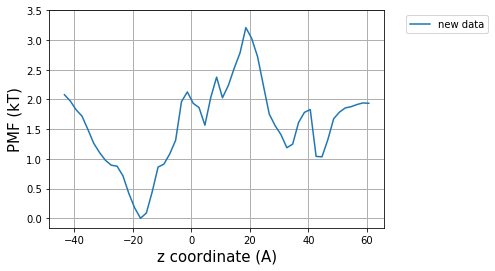

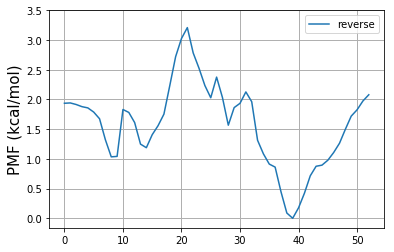

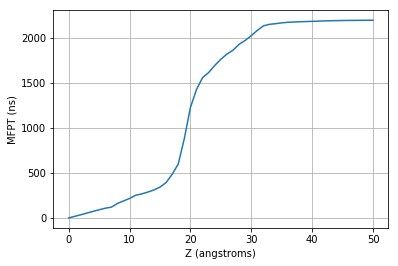

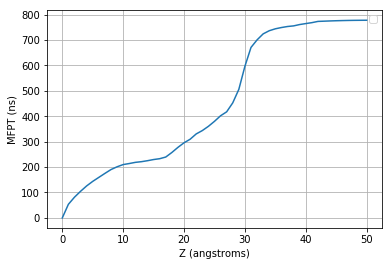

In [9]:
######################### Plot raw PMF and MFPT with window Index ##################

###### PMF ###########
tempVec=-kbT*np.log(testEscapeData['piVec']) #-log(piVec) is PMF in kT
tempVec=tempVec-np.min(tempVec)
#windowCenters=np.arange(-49.4,62.6,2.0)
windowCenters=np.arange(-43.4,62.6,2.0)
#oldVec=-kbT*np.log(old_EscapeData['piVec']) #-log(piVec) is PMF in kT
#oldVec=oldVec-np.min(oldVec)

#index22Vec=-kbT*np.log(index22_EscapeData['piVec']) #-log(piVec) is PMF in kT
#index22Vec=index22Vec-np.min(index22Vec)

plt.plot(windowCenters,tempVec,label='new data')
#plt.plot(oldVec,label='last week data')
#plt.plot(windowCenters,index22Vec,label='old')
plt.yticks(np.arange(0,4,0.5))
plt.xlabel("z coordinate (A)",size=15)
plt.ylabel("PMF (kT)",size=15)
plt.grid( linestyle='-', linewidth=1)
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.show()

##### reverse PMF #########
revVec=-kbT*np.log(rev_testEscapeData['piVec']) #-log(piVec) is PMF in kT
revVec=revVec-np.min(revVec)
plt.plot(revVec,label='reverse')
plt.yticks(np.arange(0,4,0.5))
plt.ylabel("PMF (kcal/mol)",size=15)
plt.grid( linestyle='-', linewidth=1)
plt.legend()
plt.show()

######  MFPT  ############
tauVec=QdataDict['tauVec']
rev_tauVec=rev_QdataDict['tauVec']

#print("tauVec",tauVec)
#print("rev_tauVec", rev_tauVec)
frq=1e-3 #frame rate in ns
plt.plot(
    np.sort(tauVec-np.min(tauVec))*frq)
plt.xlabel('Z (angstroms)')
plt.ylabel('MFPT (ns)')
plt.grid(True)
plt.show()

###### reverse MFPT ##########
plt.plot(
   np.sort(rev_tauVec-np.min(rev_tauVec))*frq)
plt.xlabel('Z (angstroms)')
plt.ylabel('MFPT (ns)')
plt.grid(True)
plt.legend()
plt.show()

('len', 52, 51)


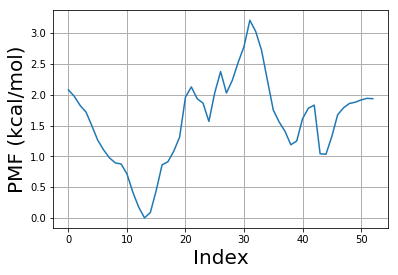

NameError: name 'index22_QdataDict' is not defined

In [10]:
############### Plot PMF and MFPT with z-axis #################
windowCenters=np.arange(-43.4,60.6,2.0)
#windowCenters=np.arange(-49.4,62.6,2.0)
#milestoneCenters=np.arange(-41.4,60.6,2.0)
milestoneCenters=(windowCenters[1:]+windowCenters[:-1])/2
print("len", len(windowCenters),len(milestoneCenters))
###### PMF ###########
tempVec=-kbT*np.log(testEscapeData['piVec']) #-log(piVec) is PMF in kT
tempVec=tempVec-np.min(tempVec)
plt.plot( tempVec)
#plt.yticks(np.arange(0,4,0.5))
plt.ylabel("PMF (kcal/mol)",size=20)
plt.xlabel('Index', size=20)
#plt.xticks(np.arange(-50,65,10))
#plt.xlim(-55,65)
plt.grid( linestyle='-', linewidth=1)
plt.show()

######  MFPT  ############
def reverse(lst):
    return [ele for ele in reversed(lst)]

tauVec=QdataDict['tauVec']
rev_tauVec=rev_QdataDict['tauVec']
index22_tauVec=index22_QdataDict['tauVec']
frq=1e-3 #frame rate in ns

plt.plot(milestoneCenters,
    np.sort(tauVec-np.min(tauVec))*frq,label='forward new')
plt.plot(milestoneCenters,
        np.sort(index22_tauVec-np.min(index22_tauVec))*frq,label='old')

#reverse(milestoneCenters)
plt.plot(reverse(milestoneCenters),
    np.sort(rev_tauVec-np.min(rev_tauVec))*frq,label="backward")

plt.xlabel('Z coordinate (A)', size=20)
plt.ylabel('MFPT (ns)',size=20)
#plt.xticks(np.arange(-50,65,10))
#plt.xlim(-55,65)
plt.grid(True)
plt.legend()
plt.show()

In [11]:
import gridData 
import plotly as ply
from plotly import graph_objs as go
import scipy as sp
from scipy import integrate
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [12]:
kb=0.001985875 #kcal/mol
simTemp=310.15
kbT=kb*simTemp

In [13]:
#### +200mV with ligands #####
volGridPos_lig=gridData.Grid('script_data/wenjuan_k_density/200mV_cladens_pos27Lig.dx')
Y,X,Z=np.meshgrid(volGridPos_lig.midpoints[1],
                  volGridPos_lig.midpoints[0],
                  volGridPos_lig.midpoints[2])
gridDataTablePos_lig=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGridPos_lig.grid.flatten()
})

meanZtablePos_lig=gridDataTablePos_lig[
        np.sqrt(gridDataTablePos_lig.X**2 + gridDataTablePos_lig.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulkPos_lig=sp.integrate.simps(meanZtablePos_lig.Density,meanZtablePos_lig.Z)
#print bulk

logPos_lig=-kbT*np.log(meanZtablePos_lig.Density/bulkPos_lig)
Pos_lig_densPMF=logPos_lig-np.min(logPos_lig)

#### -200mV with ligands #####
volGridNeg_lig=gridData.Grid('script_data/wenjuan_k_density/200mV_cladens_neg27Lig.dx')
Y,X,Z=np.meshgrid(volGridNeg_lig.midpoints[1],
                  volGridNeg_lig.midpoints[0],
                  volGridNeg_lig.midpoints[2])
gridDataTableNeg_lig=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGridNeg_lig.grid.flatten()
})

meanZtableNeg_lig=gridDataTableNeg_lig[
        np.sqrt(gridDataTableNeg_lig.X**2 + gridDataTableNeg_lig.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulkNeg_lig=sp.integrate.simps(meanZtableNeg_lig.Density,meanZtableNeg_lig.Z)
#print bulk

logNeg_lig=-kbT*np.log(meanZtableNeg_lig.Density/bulkNeg_lig)
Neg_lig_densPMF=logNeg_lig-np.min(logNeg_lig)
### -200mV without Ligs ### 
volGridNeg=gridData.Grid('script_data/wenjuan_k_density/200mV_cladens_neg_noLig.dx')
Y,X,Z=np.meshgrid(volGridNeg.midpoints[1],
                  volGridNeg.midpoints[0],
                  volGridNeg.midpoints[2])
gridDataTableNeg=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGridNeg.grid.flatten()
})

meanZtableNeg=gridDataTableNeg[
        np.sqrt(gridDataTableNeg.X**2 + gridDataTableNeg.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulkNeg=sp.integrate.simps(meanZtableNeg.Density,meanZtableNeg.Z)
#print bulk

logNeg=-kbT*np.log(meanZtableNeg.Density/bulkNeg)
Neg_densPMF=logNeg-np.min(logNeg)

#### +200mV no ligand ####
volGridPos=gridData.Grid('script_data/wenjuan_k_density/200mV_cladens_pos_noLig.dx')
Y,X,Z=np.meshgrid(volGridPos.midpoints[1],
                  volGridPos.midpoints[0],
                  volGridPos.midpoints[2])
gridDataTablePos=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGridPos.grid.flatten()
})

meanZtablePos=gridDataTablePos[
        np.sqrt(gridDataTablePos.X**2 + gridDataTablePos.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulkPos=sp.integrate.simps(meanZtablePos.Density,meanZtablePos.Z)
#print bulk

logPos=-kbT*np.log(meanZtablePos.Density/bulkPos)
Pos_densPMF=logPos-np.min(logPos)

#### +300mV no ligand ####
volGrid_300PosNoLig=gridData.Grid('script_data/wenjuan_k_density/300mV_cladens_pos_noLig.dx')
Y,X,Z=np.meshgrid(volGrid_300PosNoLig.midpoints[1],
                  volGrid_300PosNoLig.midpoints[0],
                  volGrid_300PosNoLig.midpoints[2])
gridDataTable_300PosNoLig=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGrid_300PosNoLig.grid.flatten()
})

meanZtable_300PosNoLig=gridDataTable_300PosNoLig[
        np.sqrt(gridDataTable_300PosNoLig.X**2 + gridDataTable_300PosNoLig.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulk_300PosNoLig=sp.integrate.simps(meanZtable_300PosNoLig.Density,meanZtable_300PosNoLig.Z)
#print bulk

log_300PosNoLig=-kbT*np.log(meanZtable_300PosNoLig.Density/bulk_300PosNoLig)
Pos300NoLig_densPMF=log_300PosNoLig-np.min(log_300PosNoLig)

#### -300mV no ligand ####
volGrid_300NegNoLig=gridData.Grid('script_data/wenjuan_k_density/300mV_cladens_neg_noLig.dx')
Y,X,Z=np.meshgrid(volGrid_300NegNoLig.midpoints[1],
                  volGrid_300NegNoLig.midpoints[0],
                  volGrid_300NegNoLig.midpoints[2])
gridDataTable_300NegNoLig=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGrid_300NegNoLig.grid.flatten()
})

meanZtable_300NegNoLig=gridDataTable_300NegNoLig[
        np.sqrt(gridDataTable_300NegNoLig.X**2 + gridDataTable_300NegNoLig.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulk_300NegNoLig=sp.integrate.simps(meanZtable_300NegNoLig.Density,meanZtable_300NegNoLig.Z)
#print bulk

log_300NegNoLig=-kbT*np.log(meanZtable_300NegNoLig.Density/bulk_300NegNoLig)
Neg300NoLig_densPMF=log_300NegNoLig-np.min(log_300NegNoLig)

#### +300mV 27 ligands ####
volGrid_300Pos27Lig=gridData.Grid('script_data/wenjuan_k_density/300mV_cladens_pos_27Lig.dx')
Y,X,Z=np.meshgrid(volGrid_300Pos27Lig.midpoints[1],
                  volGrid_300Pos27Lig.midpoints[0],
                  volGrid_300Pos27Lig.midpoints[2])
gridDataTable_300Pos27Lig=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGrid_300Pos27Lig.grid.flatten()
})

meanZtable_300Pos27Lig=gridDataTable_300Pos27Lig[
        np.sqrt(gridDataTable_300Pos27Lig.X**2 + gridDataTable_300Pos27Lig.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulk_300Pos27Lig=sp.integrate.simps(meanZtable_300Pos27Lig.Density,meanZtable_300Pos27Lig.Z)
#print bulk

log_300Pos27Lig=-kbT*np.log(meanZtable_300Pos27Lig.Density/bulk_300Pos27Lig)
Pos30027Lig_densPMF=log_300Pos27Lig-np.min(log_300Pos27Lig)

#### -300mV 27 ligands ####
volGrid_300Neg27Lig=gridData.Grid('script_data/wenjuan_k_density/300mV_cladens_neg_27Lig.dx')
Y,X,Z=np.meshgrid(volGrid_300Neg27Lig.midpoints[1],
                  volGrid_300Neg27Lig.midpoints[0],
                  volGrid_300Neg27Lig.midpoints[2])
gridDataTable_300Neg27Lig=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGrid_300Neg27Lig.grid.flatten()
})

meanZtable_300Neg27Lig=gridDataTable_300Neg27Lig[
        np.sqrt(gridDataTable_300Neg27Lig.X**2 + gridDataTable_300Neg27Lig.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()

bulk_300Neg27Lig=sp.integrate.simps(meanZtable_300Neg27Lig.Density,meanZtable_300Neg27Lig.Z)
#print bulk

log_300Neg27Lig=-kbT*np.log(meanZtable_300Neg27Lig.Density/bulk_300Neg27Lig)
Neg30027Lig_densPMF=log_300Neg27Lig-np.min(log_300Neg27Lig)

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning:

divide by zero encountered in log

C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning:

divide by zero encountered in log



In [14]:
#### k density plot for non-voltage without ligand ####
volGrid=gridData.Grid('script_data/wenjuan_k_density/nonVol_cladens_noLig.dx')
Y,X,Z=np.meshgrid(volGrid.midpoints[1],
                  volGrid.midpoints[0],
                  volGrid.midpoints[2])
gridDataTable=pd.DataFrame({
    'X':X.flatten(),
    'Y':Y.flatten(),
    'Z':Z.flatten(),
    'Density':volGrid.grid.flatten()
})

meanZtable=gridDataTable[
        np.sqrt(gridDataTable.X**2 + gridDataTable.Y**2)<=30.0
    ][['Z','Density']].groupby('Z').aggregate('sum').reset_index()
#t1=meanZtable.query("Z<=-38 ")
#t2=meanZtable.query("Z>-40 and Z<40")
#t3=meanZtable.query("Z>=40 ")
#middle=sp.integrate.simps(t2.Density,t2.Z)
#bulk=sp.integrate.simps(t1.Density,t1.Z)+sp.integrate.simps(t3.Density,t3.Z)
bulk=sp.integrate.simps(meanZtable.Density,meanZtable.Z)
print bulk

logD=-kbT*np.log(meanZtable.Density/bulk)
densPMF=logD-np.min(logD)

35.1895138365492


C:\Users\19094\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning:

divide by zero encountered in log



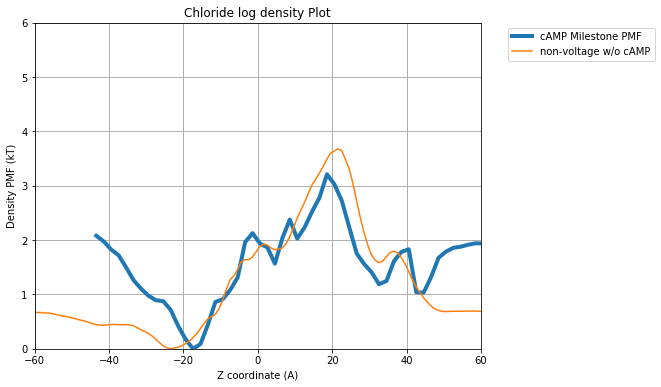

In [15]:
plt.figure(figsize=(8,6))
windowCenters=np.arange(-43.4,62.6,2.0)
plt.plot(windowCenters,tempVec,label='cAMP Milestone PMF',linewidth=4)
#plt.plot(meanZtablePos_lig.Z,Pos_lig_densPMF,label='+200mV with 27 cAMP')
#plt.plot(meanZtableNeg_lig.Z,Neg_lig_densPMF,label='-200mV with 27 cAMP',linestyle='-.')
plt.plot(meanZtable.Z,densPMF,label='non-voltage w/o cAMP') 
#plt.plot(meanZtableNeg.Z,Neg_densPMF,label='-200mV w/o cAMP',linestyle='-.')
#plt.plot(meanZtablePos.Z,Pos_densPMF,label='+200mV w/o cAMP')
#plt.plot(meanZtable_300PosNoLig.Z,Pos300NoLig_densPMF,label='+300mV w/o cAMP')
#plt.plot(meanZtable_300NegNoLig.Z,Neg300NoLig_densPMF,label='-300mV w/o cAMP',linestyle='-.')
#plt.plot(meanZtable_300Pos27Lig.Z,Pos30027Lig_densPMF,label='+300mV with 27 cAMP')
#plt.plot(meanZtable_300Neg27Lig.Z,Neg30027Lig_densPMF,label='-300mV with 27 cAMP',linestyle='-.')
plt.xlim(-60,60)
plt.ylim(0,6)
#plt.yticks(np.arange(0,3,0.5))
plt.xlabel("Z coordinate (A)")
plt.ylabel("Density PMF (kT)")
plt.title("Chloride log density Plot")
plt.grid( linestyle='-', linewidth=1)
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

plt.show()